# Plant Leaf Image Capture, Upload, and Analysis with Firebase

This Jupyter Notebook demonstrates a workflow for capturing a plant leaf image using a webcam, uploading it to Firebase Storage, and performing image analysis to detect faces, leaves, and brown spots. The steps include:

1. **Setup and Installation**  
    - Installs required packages such as `pyrebase4` for Firebase integration.

2. **Image Capture and Upload**  
    - Captures a photo using the computer's webcam.
    - Saves the image locally and uploads it to Firebase Storage using credentials stored in environment variables.

3. **Image Retrieval**  
    - Generates a download URL for the uploaded image.
    - Downloads the image from Firebase for further processing.

4. **Face Detection**  
    - Uses OpenCV's Haar cascade classifier to detect faces in the image and annotates them.

5. **Leaf Detection**  
    - Converts the image to HSV color space and applies color segmentation to detect green regions (leaves).
    - Draws contours around detected leaves.

6. **Leaf Grayscale Extraction**  
    - Applies the leaf mask to the grayscale image to isolate detected leaves.

7. **Brown Spot Detection**  
    - Defines a color range for brown in HSV and detects brown spots (potentially indicating disease or damage).
    - Uses edge detection and contour finding to highlight brown areas.

8. **Brown Spot Grayscale Extraction**  
    - Applies the brown mask to the grayscale image to isolate detected brown spots.

Throughout the notebook, visualizations are provided using Matplotlib to display the results of each analysis step. This workflow can be adapted for plant disease detection, automated monitoring, or educational purposes.

## Why Use Firebase?

Firebase is a powerful cloud platform that provides secure, scalable, and real-time backend services for applications. In this workflow, we use Firebase Storage to:

- **Centralize Image Storage:** Store captured plant leaf images in the cloud, making them accessible from anywhere and on any device.
- **Enable Collaboration:** Allow multiple users or devices to upload and access images without manual file transfers.
- **Simplify Integration:** Easily integrate with Python and other platforms using Firebase's APIs.
- **Enhance Security:** Manage access and permissions for stored images using Firebase Authentication and security rules.
- **Support Scalability:** Effortlessly handle large numbers of images and users as the project grows.

By leveraging Firebase, we streamline the process of capturing, uploading, and analyzing images in a reliable and efficient manner.

In [ ]:
# !py -m pip install pyrebase4
# !py -m pip install --upgrade setuptools
# !py -m pip install opencv-python
# !py -m pip install matplotlib
# !py -m pip install dotenv
# !py -m pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached setuptools-80.3.1-py3-none-any.whl.metadata (6.5 kB)
Using cached setuptools-80.3.1-py3-none-any.whl (1.2 MB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import datetime
import time
import pyrebase
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Your Firebase Web Config from environment variables
config = {
    "apiKey": os.getenv("FIREBASE_API_KEY"),
    "authDomain": os.getenv("FIREBASE_AUTH_DOMAIN"),
    "projectId": os.getenv("FIREBASE_PROJECT_ID"),
    "storageBucket": os.getenv("FIREBASE_STORAGE_BUCKET"),
    "messagingSenderId": os.getenv("FIREBASE_MESSAGING_SENDER_ID"),
    "appId": os.getenv("FIREBASE_APP_ID"),
    "databaseURL": os.getenv("FIREBASE_DATABASE_URL", "")
}

# Initialize Firebase
firebase = pyrebase.initialize_app(config)
storage = firebase.storage()

In [ ]:
# Create a local storage folder
save_folder = r"G:\My Drive\University Files\4th Semester\Machine Learning\Final Project\Firebase Upload\photos"
os.makedirs(save_folder, exist_ok=True)

# Take a photo
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
filename = f"photo_{timestamp}.jpg"
filepath = os.path.join(save_folder, filename)

import cv2

# Capture photo using OpenCV
camera = cv2.VideoCapture(0)
if not camera.isOpened():
    raise RuntimeError("Could not access the camera.")

ret, frame = camera.read()
if not ret:
    raise RuntimeError("Failed to capture image from the camera.")

# Save the captured photo
cv2.imwrite(filepath, frame)
camera.release()

# Check if the file was created successfully
if not os.path.exists(filepath):
    raise FileNotFoundError(f"File not found: {filepath}")

print(f"Photo saved at {filepath}")

# Upload to Firebase Storage
firebase_path = f"photos/{filename}"
storage.child(firebase_path).put(filepath)

print(f"Photo {filename} successfully uploaded to Firebase Storage ({firebase_path})")

?? Foto disimpan di G:\My Drive\University Files\4th Semester\Machine Learning\Final Project\Firebase Upload\photos\photo_2025-05-08_16-13.jpg
? Foto photo_2025-05-08_16-13.jpg berhasil diunggah ke Firebase Storage (photos/photo_2025-05-08_16-13.jpg)


In [ ]:
# Generate the download URL for the uploaded file
file_url = storage.child(firebase_path).get_url(None)
print(f"File can be accessed at: {file_url}")

File can be accessed at: https://firebasestorage.googleapis.com/v0/b/plantesa-c3798.firebasestorage.app/o/photos%2FleafFungus.jpg?alt=media


This block of code retrieves the download URL for the image that was just uploaded to Firebase Storage. It uses the `storage.child(firebase_path).get_url(None)` method to generate a publicly accessible URL for the uploaded file, which is then printed. This URL can be used to access or download the image from anywhere, and will be used in subsequent steps for image analysis and processing.This block of code retrieves the download URL for the image that was just uploaded to Firebase Storage. It uses the `storage.child(firebase_path).get_url(None)` method to generate a publicly accessible URL for the uploaded file, which is then printed. This URL can be used to access or download the image from anywhere, and will be used in subsequent steps for image analysis and processing.

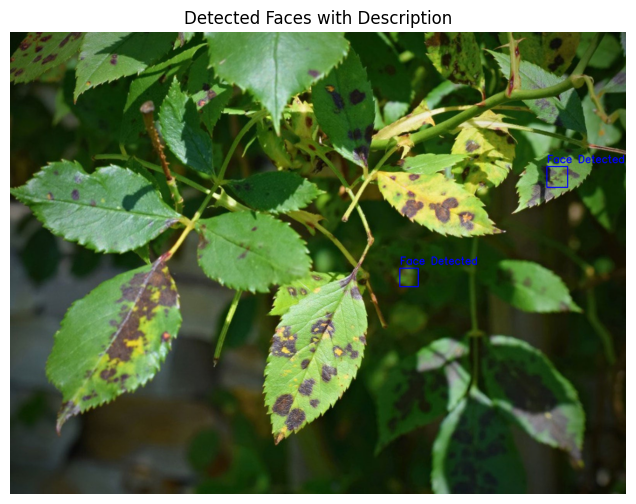

In [17]:
import cv2
import numpy as np
import requests

# Download the image from Firebase
response = requests.get(file_url)
if response.status_code == 200:
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
else:
    raise RuntimeError(f"Failed to download the image from Firebase. Status code: {response.status_code}")

# Load the Haar cascade for face detection
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert the image to grayscale for face detection
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around detected faces and add a description
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(image, "Face Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

# Display the image with detected faces and description
import matplotlib.pyplot as plt

# Convert the image from BGR to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Detected Faces with Description")
plt.show()


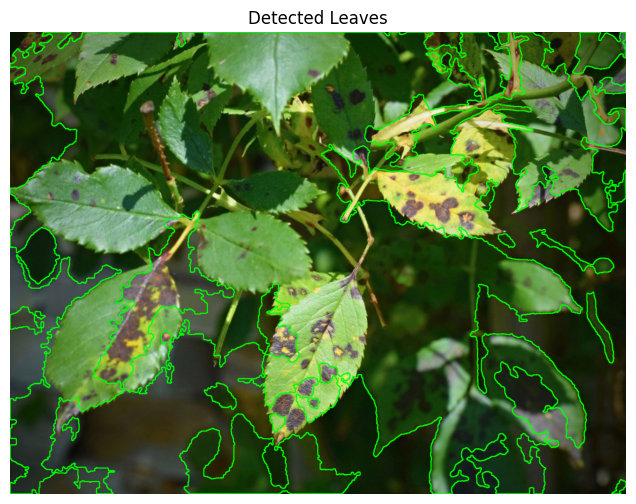

In [27]:
# Ensure the image is defined by downloading it again
response = requests.get(file_url)
if response.status_code == 200:
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
else:
    raise RuntimeError(f"Failed to download the image from Firebase. Status code: {response.status_code}")

# Convert the image to HSV color space for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for green color in HSV
lower_green = np.array([40, 40, 40])  # Adjust these values as needed
upper_green = np.array([85, 255, 255])

# Create a mask for green color
mask = cv2.inRange(hsv_image, lower_green, upper_green)

# Perform morphological operations to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
leaf_image = image.copy()
for contour in contours:
    if cv2.contourArea(contour) > 500:  # Filter small contours
        cv2.drawContours(leaf_image, [contour], -1, (0, 255, 0), 2)

# Display the image with detected leaves
leaf_image_rgb = cv2.cvtColor(leaf_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(leaf_image_rgb)
plt.axis('off')
plt.title("Detected Leaves")
plt.show()

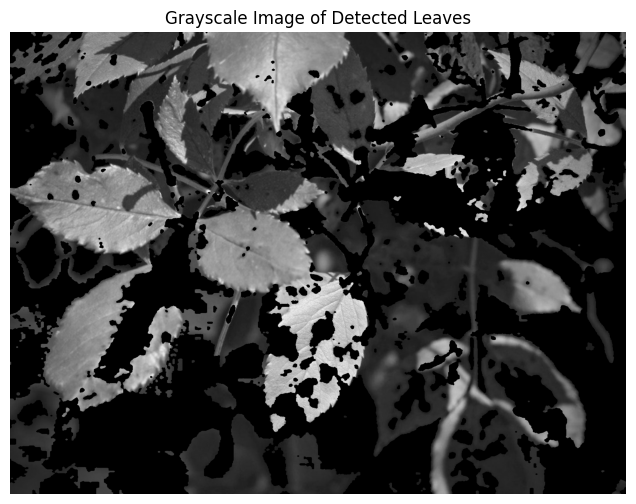

In [28]:
# Apply the mask to the grayscale image to isolate the detected leaves
leaf_gray_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

# Display the grayscale image of the detected leaves
plt.figure(figsize=(10, 6))
plt.imshow(leaf_gray_image, cmap='gray')
plt.axis('off')
plt.title("Grayscale Image of Detected Leaves")
plt.show()

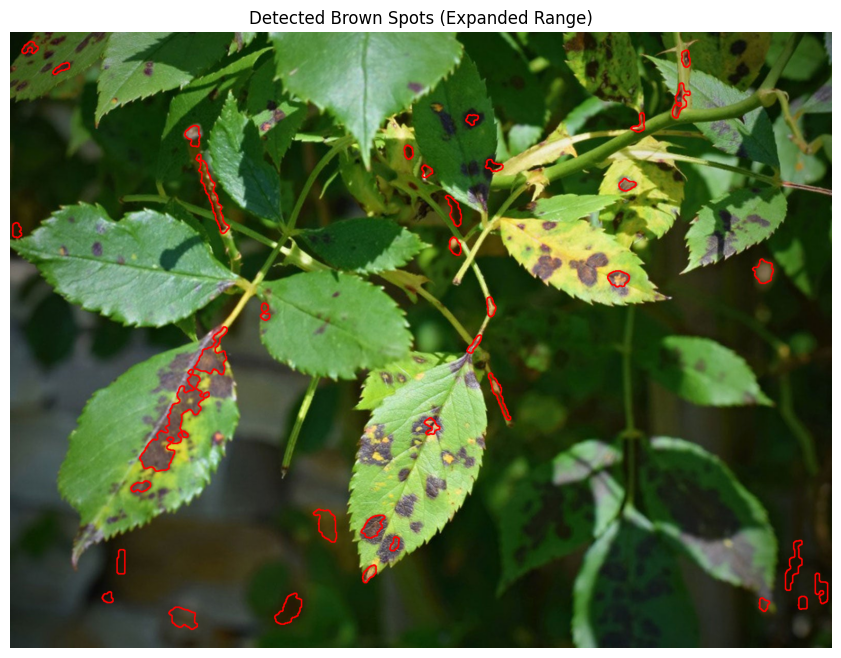

In [35]:
# Define the range for brown color in HSV (expanded range for better sensitivity)
lower_brown = np.array([8, 40, 20])  # Lower thresholds expanded
upper_brown = np.array([25, 255, 220])  # Upper thresholds expanded

# Create a mask for brown color
brown_mask = cv2.inRange(hsv_image, lower_brown, upper_brown)

# Perform morphological operations to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # Larger kernel for better noise removal
brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_CLOSE, kernel)
brown_mask = cv2.morphologyEx(brown_mask, cv2.MORPH_OPEN, kernel)

# Find contours in the brown mask
brown_contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
brown_image = image.copy()
# Apply edge detection using Canny
edges = cv2.Canny(brown_mask, 50, 150)

# Find contours in the edge-detected image
edge_contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
for contour in edge_contours:
    if cv2.contourArea(contour) > 300:  # Filter small contours
        cv2.drawContours(brown_image, [contour], -1, (0, 0, 255), 2)

# Display the image with detected brown spots
brown_image_rgb = cv2.cvtColor(brown_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(brown_image_rgb)
plt.axis('off')
plt.title("Detected Brown Spots (Expanded Range)")
plt.show()


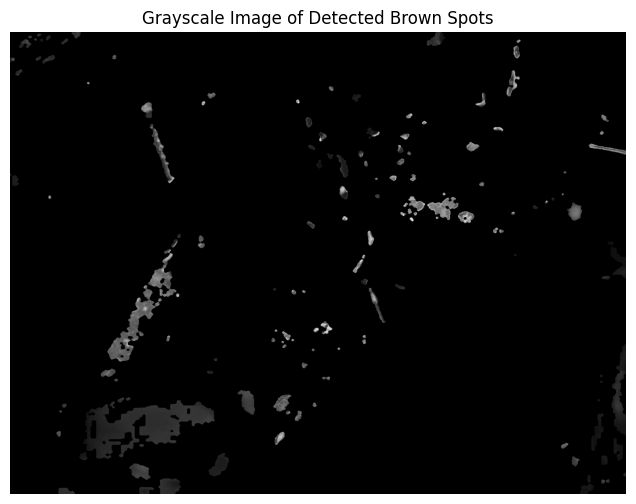

In [37]:
# Apply the brown mask to the grayscale image to isolate the detected brown spots
brown_spots_gray_image = cv2.bitwise_and(gray_image, gray_image, mask=brown_mask)

# Display the grayscale image of the detected brown spots
plt.figure(figsize=(10, 6))
plt.imshow(brown_spots_gray_image, cmap='gray')
plt.axis('off')
plt.title("Grayscale Image of Detected Brown Spots")
plt.show()

In [ ]:
# Draw bounding boxes around brown spots on the grayscale image

brown_boxes_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

for contour in brown_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if cv2.contourArea(contour) > 300:  # Filter small contours (same as before)
        cv2.rectangle(brown_boxes_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(brown_boxes_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grayscale Image with Brown Spot Bounding Boxes")
plt.show()

In [ ]:
# Calculate the percentage of brown spots relative to green leaves

# Count non-zero pixels in the masks
green_pixels = np.count_nonzero(mask)
brown_pixels = np.count_nonzero(brown_mask)

if green_pixels > 0:
    brown_percentage = (brown_pixels / green_pixels) * 100
    print(f"Brown spots cover {brown_percentage:.2f}% of the green leaf area.")
else:
    print("No green leaf area detected in the image.")

In [ ]:
# Ensure timestamp is defined
if 'timestamp' not in globals():
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# Ensure filename is defined
if 'filename' not in globals():
    filename = f"photo_{timestamp}.jpg"

# Initialize Firebase Database
db = firebase.database()

# Prepare the data to send
brown_spots_data = {
    "timestamp": timestamp,
    "filename": filename,
    "brown_percentage": brown_percentage
}

# Send the data to Firebase Realtime Database
db.child("brown_spots_percentage").push(brown_spots_data)

print("Brown spots percentage uploaded to Firebase.")

In [ ]:
# Initialize Firebase Database
db = firebase.database()

# Prepare the data to send
brown_spots_data = {
    "timestamp": timestamp,
    "filename": filename,
    "brown_percentage": brown_percentage
}

# Send the data to Firebase Realtime Database
db.child("brown_spots_percentage").push(brown_spots_data)

print("Brown spots percentage uploaded to Firebase.")

In [ ]:
from tensorflow import keras
import cv2
import numpy as np

# Load the trained .keras model
model = keras.models.load_model(r'/path/to/your/local/model/leaf_model.keras') # Change to your model's path

# Preprocess the image (resize, normalize, etc.)
input_size = (256, 256)  # Change to your model's expected input size
leaf_img_resized = cv2.resize(image, input_size)
leaf_img_rgb = cv2.cvtColor(leaf_img_resized, cv2.COLOR_BGR2RGB)
leaf_img_norm = leaf_img_rgb / 255.0  # Normalize to [0, 1]
input_tensor = np.expand_dims(leaf_img_norm, axis=0)  # Add batch dimension

# Do NOT flatten the input, keep shape (1, 256, 256, 3)
predictions = model.predict(input_tensor)
predicted_class = np.argmax(predictions, axis=1)[0]

# If you have class names
class_names = [
	'Bacterial_spot',
	'Early_blight',
	'Late_blight',
	'Leaf_Mold',
	'Septoria_leaf_spot',
	'Spider_mites Two-spotted_spider_mite',
	'Target_Spot',
	'Tomato_Yellow_Leaf_Curl_Virus',
	'Tomato_mosaic_virus',
	'healthy'
]  # Replace with your actual class names
print(f"Predicted leaf condition: {class_names[predicted_class]}")

In [ ]:
# Your Firebase Web Config from environment variables
config = {
	"apiKey": os.getenv("FIREBASE_API_KEY"),
	"authDomain": os.getenv("FIREBASE_AUTH_DOMAIN"),
	"projectId": os.getenv("FIREBASE_PROJECT_ID"),
	"storageBucket": os.getenv("FIREBASE_STORAGE_BUCKET"),
	"messagingSenderId": os.getenv("FIREBASE_MESSAGING_SENDER_ID"),
	"appId": os.getenv("FIREBASE_APP_ID"),
	"databaseURL": os.getenv("FIREBASE_DATABASE_URL")
}
# Initialize Firebase Database
db = firebase.database()

# Prepare the data to send
data = {
	"timestamp": timestamp,
	"filename": filename,
	"predicted_condition": class_names[predicted_class]
}

# Send the data to Firebase Realtime Database
db.child("leaf_conditions").push(data)

print("Predicted leaf condition sent to Firebase.")

In [ ]:
# Copy the original image to avoid modifying it in-place
photo_with_brown = image.copy()

# Draw brown spot contours
for contour in brown_contours:
    if cv2.contourArea(contour) > 300:
        cv2.drawContours(photo_with_brown, [contour], -1, (0, 0, 255), 2)

# Draw the brown percentage as text
brown_text = f"Brown: {brown_percentage:.2f}%"
cv2.putText(
    photo_with_brown, brown_text, (30, 40),
    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3
)

# Draw the predicted leaf condition as text
condition_text = f"Condition: {class_names[predicted_class]}"
cv2.putText(
    photo_with_brown, condition_text, (30, 90),
    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3
)

# Draw the timestamp as text
cv2.putText(
    photo_with_brown, f"Timestamp: {timestamp}", (30, 140),
    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2
)

# Save and upload the labeled photo
labeled_photo_filename = filename.replace('.jpg', '_brown_labeled.jpg')
labeled_photo_filepath = os.path.join(save_folder, labeled_photo_filename)
labeled_photo_firebase_path = f"photos/{labeled_photo_filename}"

cv2.imwrite(labeled_photo_filepath, photo_with_brown)
print(f"Labeled photo saved locally at {labeled_photo_filepath}")

storage.child(labeled_photo_firebase_path).put(labeled_photo_filepath)
print(f"Labeled photo uploaded to Firebase Storage at {labeled_photo_firebase_path}")

# Optionally, display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(photo_with_brown, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Photo with Brown Spot Contours, Percentage, Condition, and Timestamp")
plt.show()

Example of the output 
- Source (https://www.cabidigitallibrary.org/cms/10.1079/cabicompendium.44942/asset/33190622-c146-4ffb-819a-e9082fe8e78e/assets/graphic/44942_07.jpg)
![Brown Spot Detection Example](assets/photo_2025-06-01_20-44_brown_labeled.jpg)

In [ ]:
# Prepare the data for the labeled photo
labeled_photo_data = {
    "timestamp": timestamp,
    "filename": labeled_photo_filename,
    "labeled_photo_url": storage.child(labeled_photo_firebase_path).get_url(None)
}

# Upload the labeled photo link to Firebase Realtime Database
db.child("labeled_photos").push(labeled_photo_data)

print("Labeled photo link uploaded to Firebase Realtime Database.")

In [ ]:
import datetime
# Initialize Firebase Database
db = firebase.database()

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# Calculate the next estimated time (30 minutes from the current timestamp)
next_time = (datetime.datetime.strptime(timestamp, "%Y-%m-%d_%H-%M") + datetime.timedelta(minutes=30)).strftime("%Y-%m-%d_%H-%M")

# Prepare the data for the next estimated time
next_time_data = {
    "timestamp": timestamp,
    "next_estimated_time": next_time
}

# Upload the next estimated time to Firebase Realtime Database
db.child("next_photo_estimate").push(next_time_data)

print(f"Next estimated photo time ({next_time}) uploaded to Firebase.")